In [1]:
#READING NECESSARY LIBRARIES

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from kneed import KneeLocator


In [2]:
#READING DATASET

df = pd.read_csv('iris.csv', encoding='utf-8')
print(df.info())

#how many rows and features 
rows, features=df.shape



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


In [3]:
#PREPROCESSING


#replace different types of missing values with NaN

df.replace(
    to_replace=["", " ", "NA", "null", "None", "N/A", "missing"],
    value=np.nan,
    inplace=True
)


#spliting the columns into numerical and categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=[object]).columns

#setting up imputer to handle missing values
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')


#handle missing values

df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])
if categorical_features.size > 0:
    df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])


#scaling numerical features
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numerical_features])
scaled_df = pd.DataFrame(scaled_array, columns=numerical_features, index=df.index)
df[numerical_features] = scaled_df

#encoding categorical features
if categorical_features.size > 0:
    
    encoder = OneHotEncoder(sparse_output=False, drop=None)  
    encoded_array = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_features),
        index=df.index
    )
    df = pd.concat([df[numerical_features], encoded_df], axis=1)


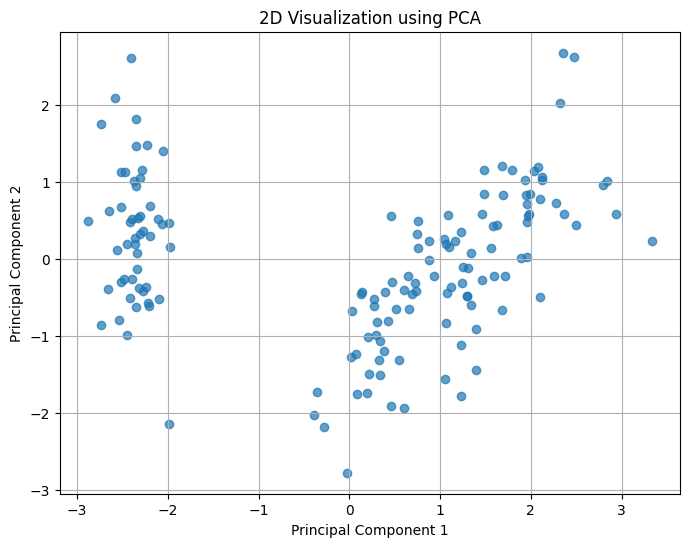

In [4]:
#DATA VISUALIZATION

#convert multiple features into 2D using PCA
pca = PCA(n_components=2)
df_2d = pca.fit_transform(df)  

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[:, 0], df_2d[:, 1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization using PCA')
plt.grid(True)
plt.show()

In [5]:
#TRAINING THE MODEL


#to find optimal number of clusters using the elbow method
#loop oer k values from 1 to 20 and calculate inertia for each k then find optimal k using KneeLocator


inertias = []
k_range = range(1, 20)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df)
    inertias.append(model.inertia_)

knee = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
optimal_k = knee.elbow

print(f"Optimal number of clusters is: {optimal_k}")
final_model = KMeans(n_clusters=optimal_k, random_state=42)


c:\Users\patha\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\patha\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\patha\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\patha\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039

Optimal number of clusters is: 4


In [6]:
#EVALUATING MODEL


#fit the final model and predict cluster labels

cluster_labels = final_model.fit_predict(df)

#get inertia and silhouette score
inertia = final_model.inertia_

silhouette = silhouette_score(df, cluster_labels)

#add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Print evaluation metrics
print(f"Final Inertia: {inertia}")
print(f"Silhouette Score: {silhouette:.4f}")

Final Inertia: 138.1728253950892
Silhouette Score: 0.4287


c:\Users\patha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


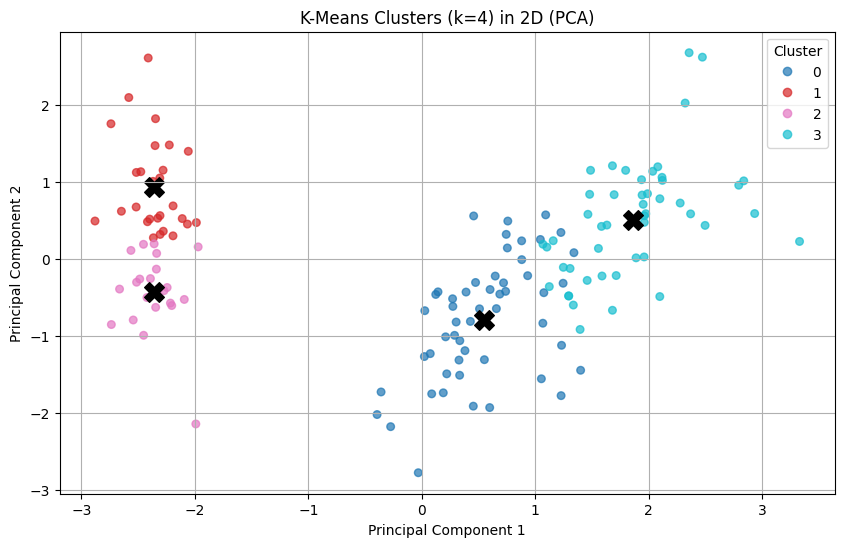

In [7]:
#DATA VISUALIZATION

#drop the 'Cluster' column for PCA transformation and store in new variable X
X = df.drop(columns=['Cluster'])

#convert multiple features into 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# get coordinates of centroids in PCA space
centroids_pca = pca.transform(final_model.cluster_centers_)

# plot the clusters in PCA space
plt.figure(figsize=(10, 6))

#x coordinates = xpca0 and y coordinates = xpca1 color the points by their cluster labels
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='tab10', s=30, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='X', s=200, label='Centroids')

#to add legend for clusters since we don't have static clusters this method is used
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title(f"K-Means Clusters (k={optimal_k}) in 2D (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()